# Parametric UMAP vs Align UMAP

Following the parameter sweep for UMAP the next step here is to determine how Parametric UMAP works for this type of data.
ParametricUMAP is a hybrid of the regular UMAP algorithm and neural networks.
The rationale for this mix is that a neural network is trained to model the neighborhood graph that UMAP needs to generate.
The best part about using a network is that one doesn't have to deal with memory issues that will arise within this data (300 dim * 100k+ words * 10 years)
Using the parameters found in the previous notebook, I explore the differences between using parametric umap first and then see how it compares to AlignUMAP (a model specifically designed for aligning multiple umap models onto one unique space).

In [1]:
from collections import OrderedDict
import itertools
from pathlib import Path
import pickle
import re

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import tqdm

from umap.aligned_umap import AlignedUMAP
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.word2vec_analysis_helper import window

# Parametric UMAP

## Unaligned Models

In [2]:
unaligned_word_models = list(
    Path("../multi_model_experiment/output/models").rglob("*model")
)
unaligned_word_models = sorted(unaligned_word_models, key=lambda x: x.stem)
unaligned_word_model_filter = list(
    filter(lambda x: "_0" in x.stem, unaligned_word_models)
)

In [3]:
word_freq_count_cutoff = 5
odd_year_subset = unaligned_word_model_filter[15:-1:2]

In [4]:
training_unaligned_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = Word2Vec.load(str(word_file)).wv
    training_unaligned_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.wv.vocab[x[1]].count > word_freq_count_cutoff
                else x[0],
                enumerate(model.wv.index2entity),
            )
        ),
    )

  0%|          | 0/3 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 33%|███▎      | 1/3 [00:03<00:07,  3.73s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 67%|██████▋   | 2/3 [00:08<00:03,  3.93s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: Depre

In [5]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [6]:
for year in tqdm.tqdm(training_unaligned_word_model_map):
    model = training_unaligned_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.wv.index2entity[: training_unaligned_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.wv.index2entity[
                : training_unaligned_word_model_map[year]["cutoff_index"]
            ],
        )
    )
    year_labels_list += [year] * len(
        model.wv.index2entity[: training_unaligned_word_model_map[year]["cutoff_index"]]
    )

  0%|          | 0/3 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 33%|███▎      | 1/3 [00:00<00:00,  2.13it/s]

('2015', (147527, 300))


 67%|██████▋   | 2/3 [00:01<00:00,  2.03it/s]

('2017', (169505, 300))


100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

('2019', (186185, 300))


In [7]:
training_unaligned_words = np.vstack(words_to_visualize)
training_unaligned_words.shape

(503217, 300)

In [8]:
umap_model_path = Path("output/unaligned_parametric_umap_model")
if not umap_model_path.exists():
    unaligned_parametric_model = ParametricUMAP(
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.99,
        n_training_epochs=1,
    )
    umap_embeddings = unaligned_parametric_model.fit_transform(training_unaligned_words)
    unaligned_parametric_model.save(str(umap_model_path))
else:
    unaligned_parametric_model = load_ParametricUMAP(umap_model_path)
    umap_embeddings = unaligned_parametric_model.transform(training_unaligned_words)

Wed Mar  2 19:45:29 2022 Building and compiling search function
Pickle of ParametricUMAP model loaded from output/unaligned_parametric_umap_model/model.pkl
Keras encoder model loaded from output/unaligned_parametric_umap_model/encoder
Keras full model loaded from output/unaligned_parametric_umap_model/parametric_model
504/504 [==============================] - 1s 1ms/step


In [9]:
train_plot_df = (
    pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    >> ply.define(year=year_labels_list, tok=token_character_list)
    >> ply.call(".dropna")
    >> ply.define(umap1="umap1.astype(float)")
)
train_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-1.772979,3.380629,2015,\
1,-1.321212,-0.058365,2015,the
2,-1.414979,0.874305,2015,","
3,-1.892773,0.889378,2015,\.
4,-1.481261,1.721570,2015,of
5,-2.023406,0.385968,2015,and
6,-2.184610,1.722276,2015,in
7,-1.382699,1.130644,2015,\-
8,-1.999938,-1.112695,2015,to
9,2.753628,4.642680,2015,\)


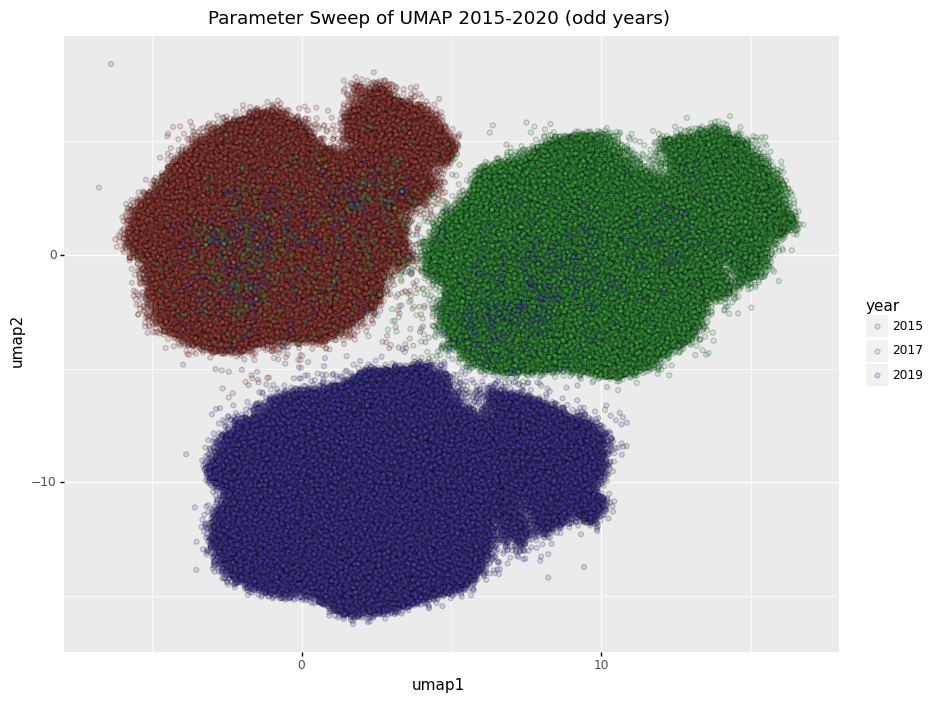

In [10]:
g = (
    p9.ggplot(
        train_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.labs(title="Parameter Sweep of UMAP 2015-2020 (odd years)")
    + p9.theme(figure_size=(10, 8))
)
print(g)

## Project held out data onto the training years

In [11]:
validation_word_model_map = dict()
for word_file in tqdm.tqdm(unaligned_word_model_filter[10:15]):
    model = Word2Vec.load(str(word_file)).wv
    validation_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.wv.vocab[x[1]].count > word_freq_count_cutoff
                else x[0],
                enumerate(model.wv.index2entity),
            )
        ),
    )

  0%|          | 0/5 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 20%|██        | 1/5 [00:01<00:07,  1.79s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 40%|████      | 2/5 [00:04<00:06,  2.03s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: Depre

In [12]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [13]:
for year in tqdm.tqdm(validation_word_model_map):
    model = validation_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.wv.index2entity[: validation_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.wv.index2entity[: validation_word_model_map[year]["cutoff_index"]],
        )
    )
    year_labels_list += [year] * len(
        model.wv.index2entity[: validation_word_model_map[year]["cutoff_index"]]
    )

  0%|          | 0/5 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 20%|██        | 1/5 [00:00<00:01,  3.63it/s]

('2010', (85285, 300))


 40%|████      | 2/5 [00:00<00:00,  3.49it/s]

('2011', (96901, 300))


 60%|██████    | 3/5 [00:00<00:00,  3.28it/s]

('2012', (106998, 300))


 80%|████████  | 4/5 [00:01<00:00,  3.04it/s]

('2013', (119889, 300))


100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

('2014', (135842, 300))


In [14]:
umap_embeddings = unaligned_parametric_model.transform(np.vstack(words_to_visualize))

545/545 [==============================] - 1s 1ms/step


In [15]:
val_plot_df = (
    pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    >> ply.define(year=year_labels_list, tok=token_character_list)
    >> ply.call(".dropna")
    >> ply.define(umap1="umap1.astype(float)")
)
val_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-0.743397,-11.469948,2010,\
1,8.138481,-0.736208,2010,the
2,-2.060732,-0.636128,2010,of
3,7.958380,-1.809183,2010,","
4,6.756214,-2.568632,2010,\.
5,-0.426220,-12.288489,2010,and
6,7.402213,-1.656024,2010,in
7,0.852333,-10.275620,2010,\-
8,-0.317728,-11.349041,2010,to
9,-0.110788,-11.708324,2010,a


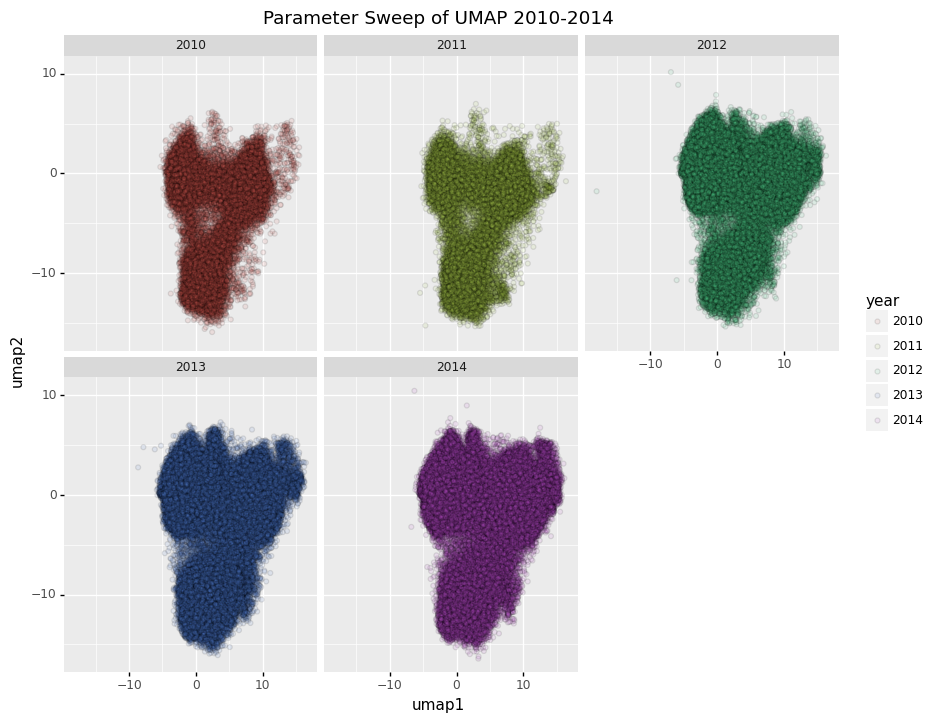

In [16]:
g = (
    p9.ggplot(
        val_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.1)
    + p9.labs(title="Parameter Sweep of UMAP 2010-2014")
    + p9.theme(figure_size=(10, 8))
    + p9.facet_wrap("year")
)
print(g)

## Aligned Models

In [17]:
aligned_word_models = list(
    Path("../multi_model_experiment/output/aligned_vectors_tmp").rglob("*kv")
)
aligned_word_models = sorted(aligned_word_models, key=lambda x: x.stem)
aligned_word_model_filter = list(filter(lambda x: "_0" in x.stem, aligned_word_models))

In [18]:
word_freq_count_cutoff = 1
odd_year_subset = aligned_word_model_filter[17:-1:2]

In [19]:
aligned_training_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = KeyedVectors.load(str(word_file))
    aligned_training_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.wv.vocab[x[1]].count > word_freq_count_cutoff
                else x[0],
                enumerate(model.wv.index2entity),
            )
        ),
    )

  0%|          | 0/2 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 50%|█████     | 1/2 [00:03<00:03,  3.25s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


In [20]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [21]:
for year in tqdm.tqdm(aligned_training_word_model_map):
    model = aligned_training_word_model_map[year]["model"]
    word_subset_matrix = model[model.wv.index2entity]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(map(lambda x: re.escape(x), model.wv.index2entity))
    year_labels_list += [year] * len(model.wv.index2entity)

  0%|          | 0/2 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 50%|█████     | 1/2 [00:00<00:00,  1.36it/s]

('2017', (264969, 300))


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

('2019', (285138, 300))


In [22]:
aligned_training_words = np.vstack(words_to_visualize)
aligned_training_words.shape

(550107, 300)

In [23]:
umap_model_path = Path("output/aligned_parametric_umap_model")
if not umap_model_path.exists():
    aligned_parametric_model = ParametricUMAP(
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=20,
        min_dist=0.99,
        n_training_epochs=1,
    )
    umap_embeddings = aligned_parametric_model.fit_transform(aligned_training_words)
    aligned_parametric_model.save(str(umap_model_path))
else:
    aligned_parametric_model = load_ParametricUMAP(umap_model_path)
    umap_embeddings = aligned_parametric_model.transform(aligned_training_words)

Wed Mar  2 19:46:53 2022 Building and compiling search function
Pickle of ParametricUMAP model loaded from output/aligned_parametric_umap_model/model.pkl
Keras encoder model loaded from output/aligned_parametric_umap_model/encoder
Keras full model loaded from output/aligned_parametric_umap_model/parametric_model
551/551 [==============================] - 1s 1ms/step


In [24]:
aligned_train_plot_df = (
    pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    >> ply.define(year=year_labels_list, tok=token_character_list)
    >> ply.call(".dropna")
    >> ply.define(umap1="umap1.astype(float)")
)
aligned_train_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,0.521893,-1.006331,2017,\
1,-2.632137,1.573548,2017,the
2,-0.829617,0.295718,2017,","
3,-1.582589,0.676961,2017,\.
4,-1.008535,0.872306,2017,of
5,-1.065159,0.689112,2017,and
6,-0.941818,1.156830,2017,in
7,-1.412632,0.398565,2017,\-
8,-3.208784,2.074306,2017,to
9,6.242187,-4.819257,2017,\)


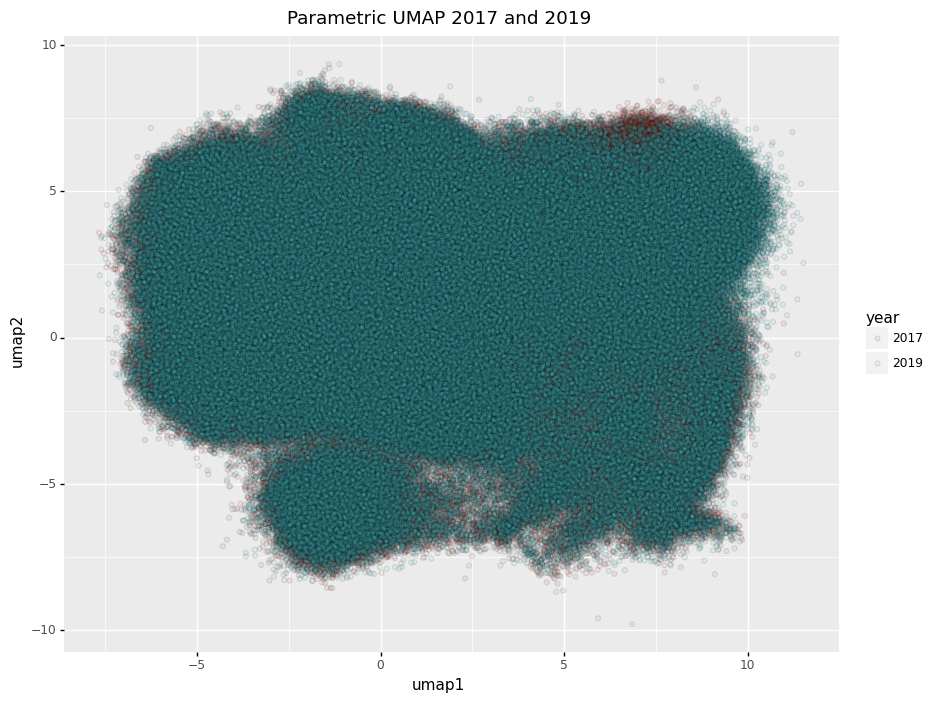

In [25]:
g = (
    p9.ggplot(
        aligned_train_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.1)
    + p9.labs(title="Parametric UMAP 2017 and 2019")
    + p9.theme(figure_size=(10, 8))
)
print(g)

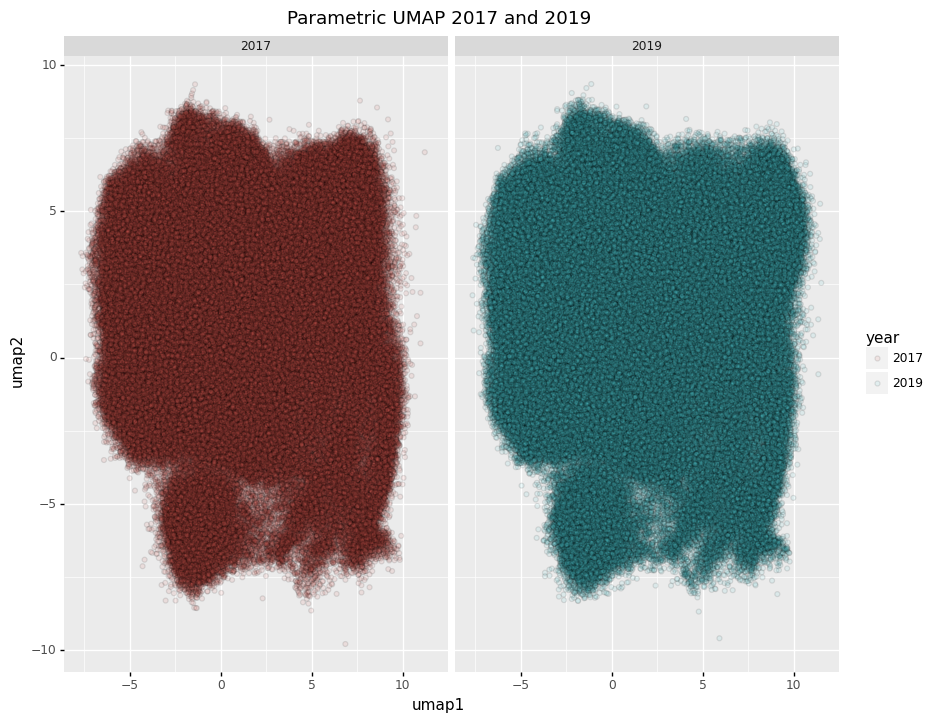

In [26]:
g = (
    p9.ggplot(
        aligned_train_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.1)
    + p9.labs(title="Parametric UMAP 2017 and 2019")
    + p9.theme(figure_size=(10, 8))
    + p9.facet_wrap("year")
)
print(g)

# Aligned UMAP

In [27]:
word_freq_count_cutoff = 5
training_word_model_map = OrderedDict()

In [28]:
for word_file in tqdm.tqdm(unaligned_word_model_filter[10:]):
    model = Word2Vec.load(str(word_file)).wv
    year = word_file.stem.split("_")[0]

    training_word_model_map[year] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.wv.vocab[x[1]].count > word_freq_count_cutoff
                else x[0],
                enumerate(model.wv.index2entity),
            )
        ),
    )

    training_word_model_map[year]["index_to_token_map"] = dict(
        zip(
            model.wv.index2entity[: training_word_model_map[year]["cutoff_index"]],
            range(
                len(
                    model.wv.index2entity[
                        : training_word_model_map[year]["cutoff_index"]
                    ]
                )
            ),
        )
    )

  0%|          | 0/11 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  9%|▉         | 1/11 [00:02<00:26,  2.67s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (A

 91%|█████████ | 10/11 [01:41<00:15, 15.76s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
100%|██████████| 11/11 [01:56<00:00, 10.60s/it]


In [29]:
relations = []
for year_one, year_two in tqdm.tqdm(window(training_word_model_map, 2)):
    year_one_map = training_word_model_map[year_one]["index_to_token_map"]
    year_two_map = training_word_model_map[year_two]["index_to_token_map"]
    relations.append(
        {
            year_one_map[tok]: year_two_map[tok]
            for tok in year_one_map
            if tok in year_two_map
        }
    )

10it [00:00, 16.09it/s]


In [30]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [31]:
for year in tqdm.tqdm(training_word_model_map):
    model = training_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.wv.index2entity[: training_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.wv.index2entity[: training_word_model_map[year]["cutoff_index"]],
        )
    )
    year_labels_list += [year] * len(
        model.wv.index2entity[: training_word_model_map[year]["cutoff_index"]]
    )

  0%|          | 0/11 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  9%|▉         | 1/11 [00:00<00:02,  3.64it/s]

('2010', (85285, 300))


 18%|█▊        | 2/11 [00:00<00:02,  3.49it/s]

('2011', (96901, 300))


 27%|██▋       | 3/11 [00:00<00:02,  3.27it/s]

('2012', (106998, 300))


 36%|███▋      | 4/11 [00:01<00:02,  3.02it/s]

('2013', (119889, 300))


 45%|████▌     | 5/11 [00:01<00:02,  2.73it/s]

('2014', (135842, 300))


 55%|█████▍    | 6/11 [00:02<00:02,  2.28it/s]

('2015', (147527, 300))


 64%|██████▎   | 7/11 [00:02<00:01,  2.05it/s]

('2016', (157142, 300))


 73%|███████▎  | 8/11 [00:03<00:01,  1.82it/s]

('2017', (169505, 300))


 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

('2018', (176358, 300))


 91%|█████████ | 10/11 [00:05<00:00,  1.55it/s]

('2019', (186185, 300))


100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

('2020', (136410, 300))


In [32]:
aligned_umap_output_path = Path("output/aligned_umap_model.pkl")
if not aligned_umap_output_path.exists():
    # runtime - 3h 44m 17s
    aligned_umap_model = AlignedUMAP(
        n_components=2,
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.99,
        alignment_window_size=2,
        alignment_regularisation=1e-3,
    )
    aligned_umap_model.fit(words_to_visualize, relations=relations)
    aligned_umap_model.embeddings_ = list(aligned_umap_model.embeddings_)
    pickle.dump(aligned_umap_model, open(str(aligned_umap_output_path), "wb"))
else:
    aligned_umap_model = pickle.load(open(str(aligned_umap_output_path), "rb"))

Wed Mar  2 19:49:45 2022 Building and compiling search function
Wed Mar  2 19:49:51 2022 Building and compiling search function
Wed Mar  2 19:49:56 2022 Building and compiling search function
Wed Mar  2 19:50:01 2022 Building and compiling search function
Wed Mar  2 19:50:07 2022 Building and compiling search function
Wed Mar  2 19:50:13 2022 Building and compiling search function
Wed Mar  2 19:50:19 2022 Building and compiling search function
Wed Mar  2 19:50:26 2022 Building and compiling search function
Wed Mar  2 19:50:33 2022 Building and compiling search function
Wed Mar  2 19:50:41 2022 Building and compiling search function
Wed Mar  2 19:50:47 2022 Building and compiling search function


In [33]:
aligned_plot_df = pd.DataFrame(
    np.vstack(aligned_umap_model.embeddings_), columns=["umap1", "umap2"]
) >> ply.define(year="year_labels_list", tok="token_character_list")
aligned_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-0.063144,-4.804184,2010,\
1,1.907398,1.905113,2010,the
2,1.925217,2.093864,2010,of
3,2.056771,2.190396,2010,","
4,2.043776,2.331739,2010,\.
5,2.112347,2.361096,2010,and
6,2.011112,1.931211,2010,in
7,3.102991,-2.526640,2010,\-
8,1.591898,2.442492,2010,to
9,1.980048,1.707056,2010,a


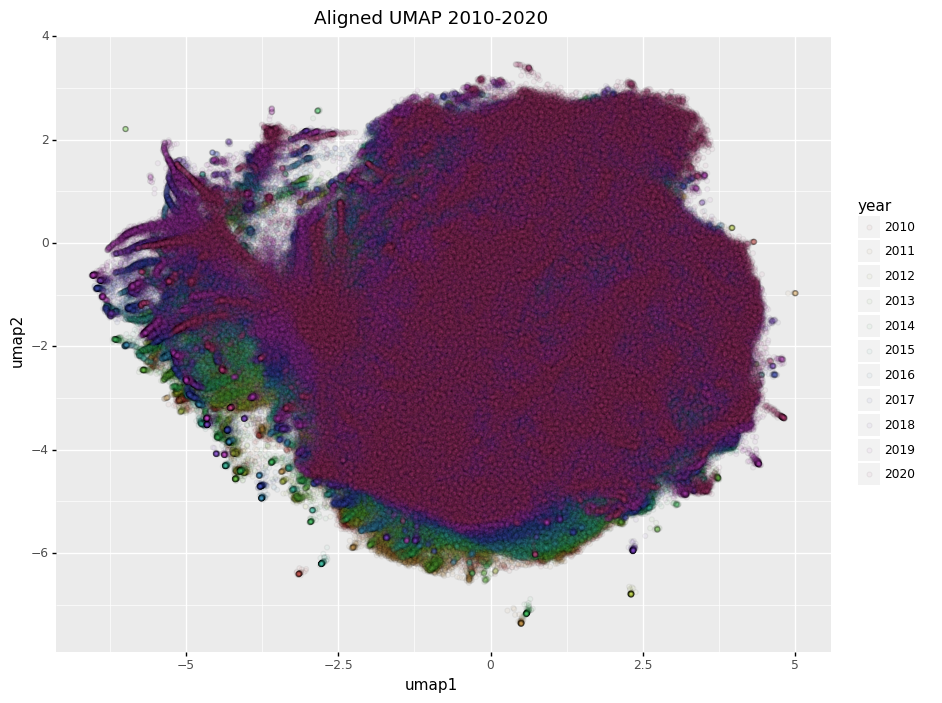

In [34]:
g = (
    p9.ggplot(
        aligned_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.05)
    + p9.labs(title="Aligned UMAP 2010-2020")
    + p9.theme(figure_size=(10, 8))
)
print(g)

# Take home messages

1. Parametric UMAP works as expected. It creates clusters based on training data and uses this training data to map new data onto those clusters. Observed this when training on odd years but projecting even years onto that.
2. Align umap might be better in terms of projections as it constructs individual umap models then aligns them overall.
3. Not sure which model to choose but I believe that alignUMAP might be the better but will see as this project unfolds.